# **Unsupervised Deep Convolutional Generative Adversarial Networks for Image Synthesis**

# **Abstract**

---
The goal of this Jupyter notebook is to train a Deep Convolutional Generative Adversarial Network (DCGAN) to generate novel face portrait images. The notebook utilizes a dataset of celebrity faces to train the DCGAN, which consists of a generator network and a discriminator network that work together to produce high-quality, realistic images.

The notebook begins with an exploration of the dataset and preprocessing steps necessary to prepare the images for training. This includes resizing and normalization of the images.

The GAN architecture used in this notebook is a DCGAN, which has been shown to be effective for image generation tasks.

In [1]:
!pip install tensorflow-gan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from tqdm import tqdm
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_gan as tfgan

"""
Main resources used: 
TF docs (https://www.tensorflow.org/tutorials/generative/dcgan),
TF Blog (Evaluation): https://blog.tensorflow.org/2022/01/summer-of-code.html,
"""

#this is data drive, use celeba dataset
drive.mount('/content/drive', force_remount=True)

batch_size = 32
image_size = (64, 64)
latent_dim = 128

#Check for gpu
physical_devices = tf.config.list_physical_devices("GPU")
data_dir = "/content/drive/MyDrive/img_align_celeba"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Mounted at /content/drive
Num GPUs Available:  1




---


**Note: TensorFlow Version 2.12.0 was used in this project**


---



In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size,
    label_mode=None,
).map(lambda x: x / 255.0)


#train_ds = train_ds.prefetch(tf.data.AUTOTUNE).cache()
print(len(train_ds))

Found 142093 files belonging to 1 classes.
4441


In [4]:
#Building Discriminator

discriminator = tf.keras.Sequential (
    [
    tf.keras.Input(shape = (64,64,3)),
    tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation='sigmoid'),
    ],
    name="discriminator"
)

print(discriminator.summary())


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

**Generator Architecture**

The architecture of DCGAN revolves in utilizing  convolutional and transpose-convolutional layers in the discriminator and generator.

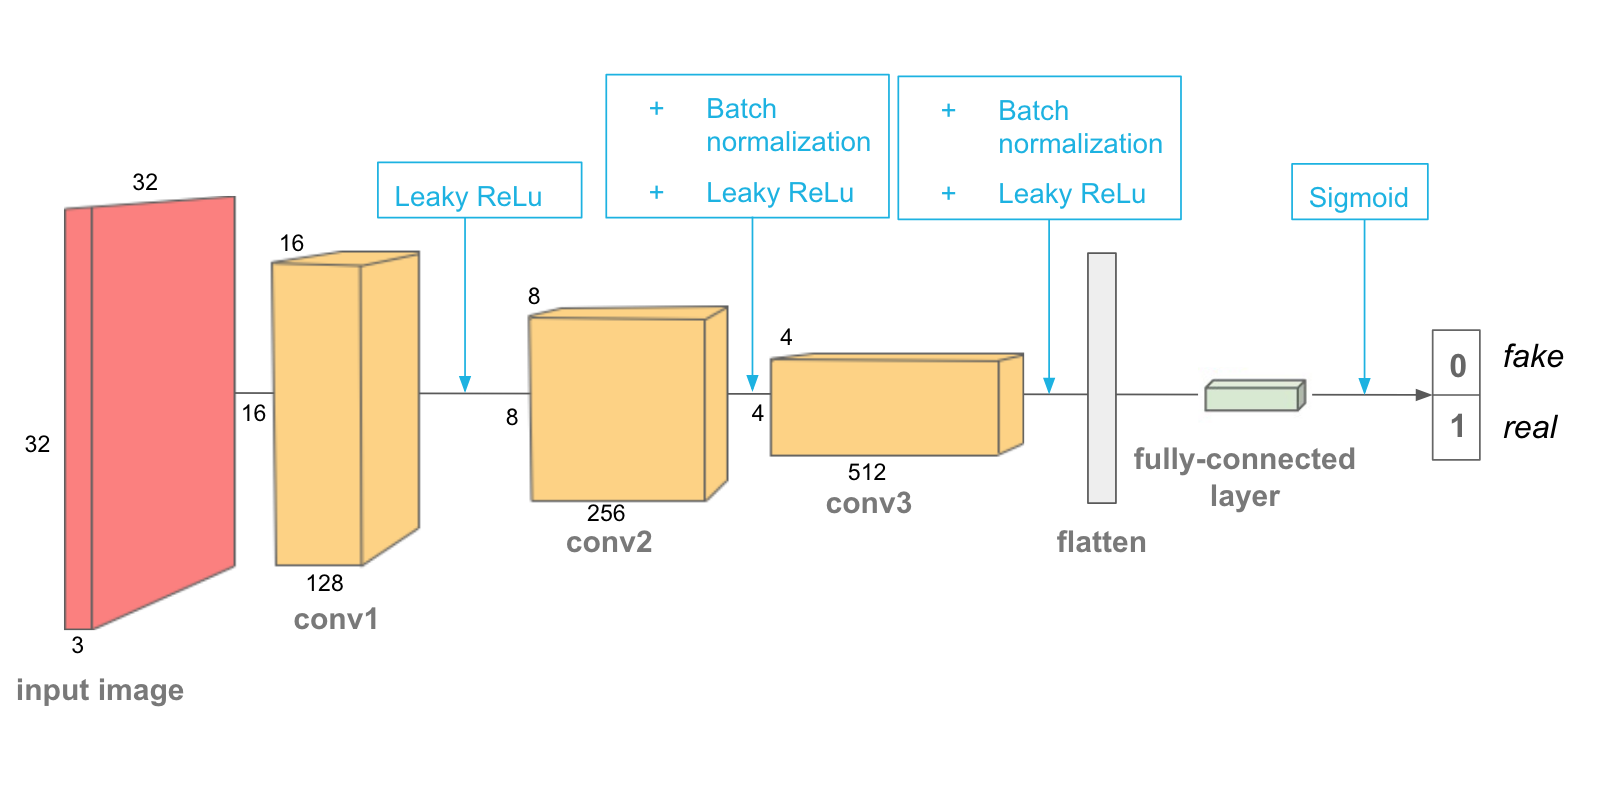

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 256)      10

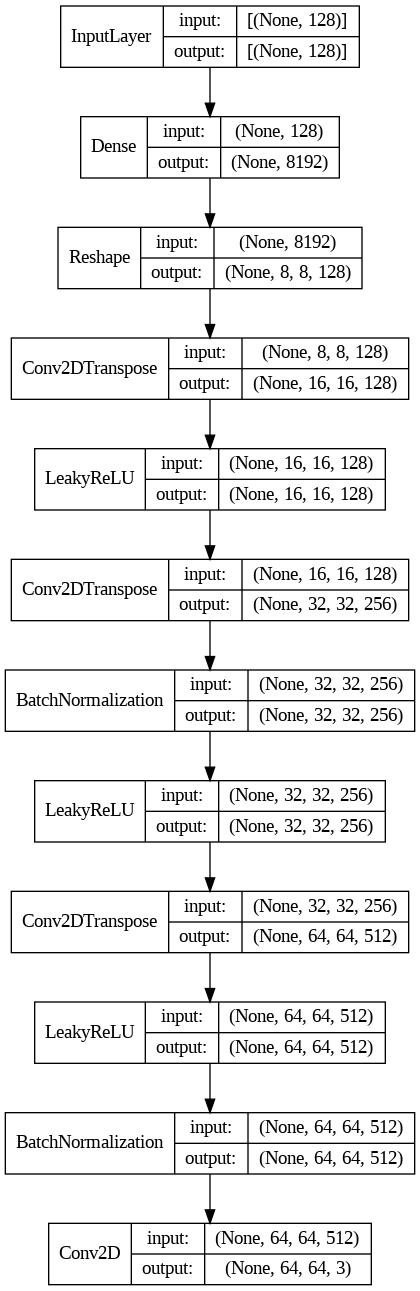

In [11]:
#Build Generator

latent_dim = 128 #128
generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(8 * 8 * 128),
        #tf.keras.layers.BatchNormalization(), #batchnorm
        tf.keras.layers.Reshape((8, 8, 128)),
        tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

tf.keras.utils.plot_model(generator, to_file='model.png', show_shapes=True, show_layer_names=False)

In [6]:
#Optimizers for Generator and Discriminators
gen_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [7]:
@tf.function 
def get_fid_score(real_image, gen_image):
  size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE
  resized_real_images = tf.image.resize(real_image, [size, size], method=tf.image.ResizeMethod.BILINEAR)
  resized_generated_images = tf.image.resize(gen_image, [size, size], method=tf.image.ResizeMethod.BILINEAR)
  num_inception_images = 1
  num_batches = batch_size // num_inception_images
  fid = tfgan.eval.frechet_inception_distance(resized_real_images, resized_generated_images, num_batches=num_batches)
  return fid

 23%|██▎       | 1000/4441 [15:25<51:05,  1.12it/s]WARNING:tensorflow:From /usr/local/lib/python3.9/dist-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/nest.py:917: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  structure[0], [func(*x) for x in entries],
/usr/local/lib/python3.9/dist-packages/keras/legacy_tf_layers/base.py:627: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied aut

Epoch 1, batch 1000: FID = 431.5455


 45%|████▌     | 2003/4441 [30:34<38:40,  1.05it/s]  

Epoch 1, batch 2000: FID = 440.9210


 68%|██████▊   | 3003/4441 [45:30<22:33,  1.06it/s]

Epoch 1, batch 3000: FID = 389.6271


 90%|█████████ | 4003/4441 [1:00:19<07:28,  1.02s/it]

Epoch 1, batch 4000: FID = 326.9133


100%|██████████| 4441/4441 [1:06:51<00:00,  1.11it/s]


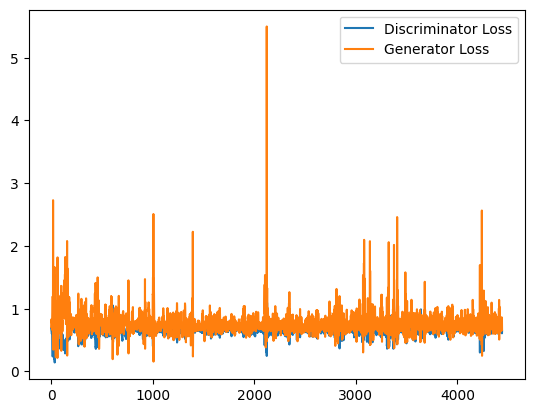

 23%|██▎       | 1003/4441 [01:31<22:21,  2.56it/s]

Epoch 2, batch 1000: FID = 303.7260


 45%|████▌     | 2003/4441 [03:02<15:48,  2.57it/s]

Epoch 2, batch 2000: FID = 258.0459


 68%|██████▊   | 3003/4441 [04:33<09:13,  2.60it/s]

Epoch 2, batch 3000: FID = 235.3643


 90%|█████████ | 4003/4441 [06:04<02:48,  2.59it/s]

Epoch 2, batch 4000: FID = 259.7372


100%|██████████| 4441/4441 [06:43<00:00, 11.01it/s]


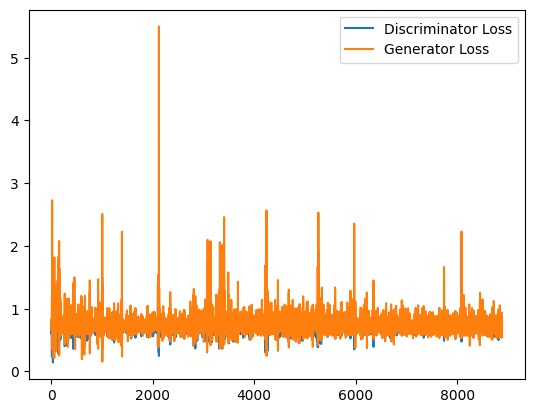

 23%|██▎       | 1002/4441 [01:31<29:20,  1.95it/s]

Epoch 3, batch 1000: FID = 234.4807


 45%|████▌     | 2002/4441 [03:01<20:57,  1.94it/s]

Epoch 3, batch 2000: FID = 225.0256


 68%|██████▊   | 3002/4441 [04:31<12:20,  1.94it/s]

Epoch 3, batch 3000: FID = 191.1649


 90%|█████████ | 4002/4441 [06:02<03:46,  1.94it/s]

Epoch 3, batch 4000: FID = 217.1953


100%|██████████| 4441/4441 [06:40<00:00, 11.08it/s]


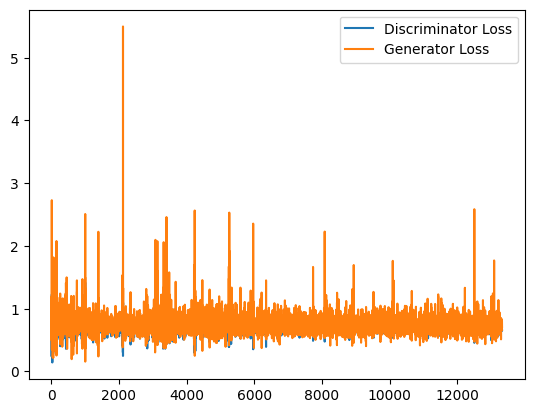

 23%|██▎       | 1002/4441 [01:30<25:23,  2.26it/s]

Epoch 4, batch 1000: FID = 212.3281


 45%|████▌     | 2002/4441 [03:01<20:54,  1.94it/s]

Epoch 4, batch 2000: FID = 232.8396


 68%|██████▊   | 3002/4441 [04:31<12:20,  1.94it/s]

Epoch 4, batch 3000: FID = 252.9655


 90%|█████████ | 4002/4441 [06:02<03:45,  1.95it/s]

Epoch 4, batch 4000: FID = 195.2423


100%|██████████| 4441/4441 [06:40<00:00, 11.08it/s]


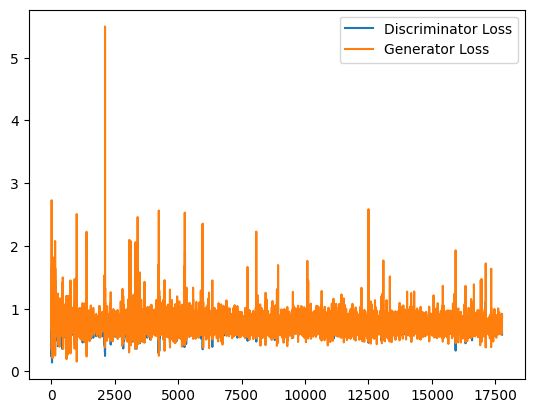

 23%|██▎       | 1003/4441 [01:30<22:06,  2.59it/s]

Epoch 5, batch 1000: FID = 189.1373


 45%|████▌     | 2003/4441 [03:01<15:29,  2.62it/s]

Epoch 5, batch 2000: FID = 196.7224


 68%|██████▊   | 3002/4441 [04:31<10:26,  2.30it/s]

Epoch 5, batch 3000: FID = 174.2934


 90%|█████████ | 4003/4441 [06:01<02:51,  2.55it/s]

Epoch 5, batch 4000: FID = 186.1632


100%|██████████| 4441/4441 [06:40<00:00, 11.10it/s]


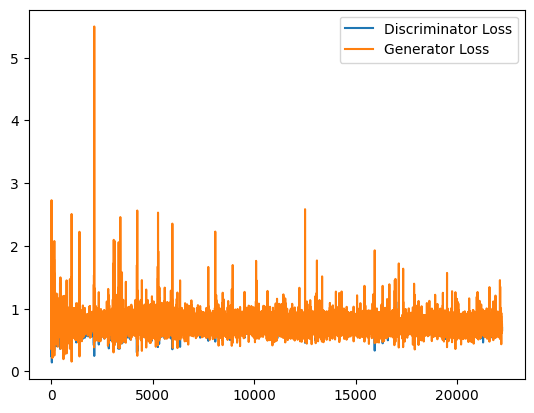

 23%|██▎       | 1003/4441 [01:30<22:04,  2.60it/s]

Epoch 6, batch 1000: FID = 198.5779


 45%|████▌     | 2003/4441 [03:01<15:50,  2.57it/s]

Epoch 6, batch 2000: FID = 223.6805


 68%|██████▊   | 3003/4441 [04:31<09:09,  2.62it/s]

Epoch 6, batch 3000: FID = 206.4571


 90%|█████████ | 4003/4441 [06:02<02:47,  2.61it/s]

Epoch 6, batch 4000: FID = 190.8563


100%|██████████| 4441/4441 [06:40<00:00, 11.08it/s]


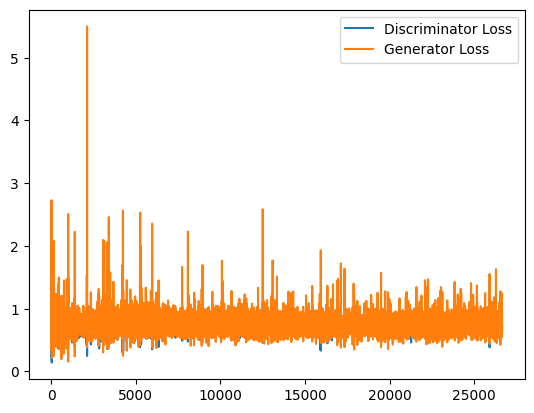

 23%|██▎       | 1003/4441 [01:31<22:04,  2.60it/s]

Epoch 7, batch 1000: FID = 184.9007


 45%|████▌     | 2003/4441 [03:01<15:47,  2.57it/s]

Epoch 7, batch 2000: FID = 196.2148


 68%|██████▊   | 3003/4441 [04:32<09:27,  2.53it/s]

Epoch 7, batch 3000: FID = 185.3639


 90%|█████████ | 4003/4441 [06:03<02:49,  2.58it/s]

Epoch 7, batch 4000: FID = 217.1916


100%|██████████| 4441/4441 [06:41<00:00, 11.05it/s]


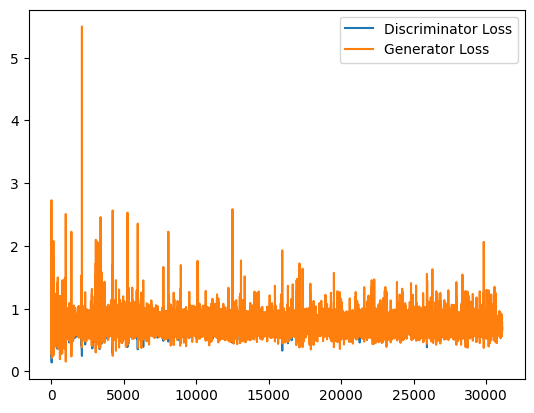

 23%|██▎       | 1003/4441 [01:31<22:27,  2.55it/s]

Epoch 8, batch 1000: FID = 186.0773


 45%|████▌     | 2003/4441 [03:02<15:59,  2.54it/s]

Epoch 8, batch 2000: FID = 180.8521


 68%|██████▊   | 3003/4441 [04:32<09:24,  2.55it/s]

Epoch 8, batch 3000: FID = 172.5046


 90%|█████████ | 4003/4441 [06:02<02:47,  2.61it/s]

Epoch 8, batch 4000: FID = 181.2009


100%|██████████| 4441/4441 [06:41<00:00, 11.06it/s]


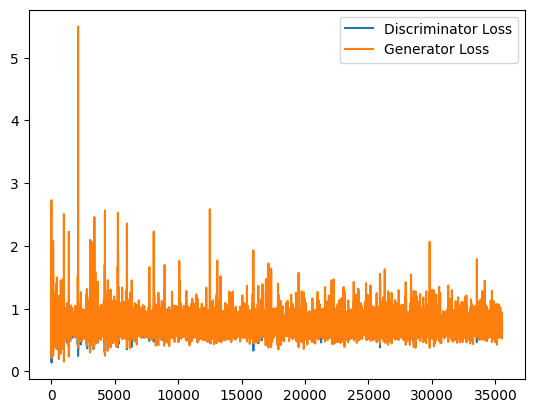

 23%|██▎       | 1003/4441 [01:30<22:08,  2.59it/s]

Epoch 9, batch 1000: FID = 169.1741


 45%|████▌     | 2003/4441 [03:01<15:41,  2.59it/s]

Epoch 9, batch 2000: FID = 179.7672


 68%|██████▊   | 3003/4441 [04:32<09:17,  2.58it/s]

Epoch 9, batch 3000: FID = 172.9215


 90%|█████████ | 4003/4441 [06:02<02:49,  2.58it/s]

Epoch 9, batch 4000: FID = 163.1001


100%|██████████| 4441/4441 [06:40<00:00, 11.08it/s]


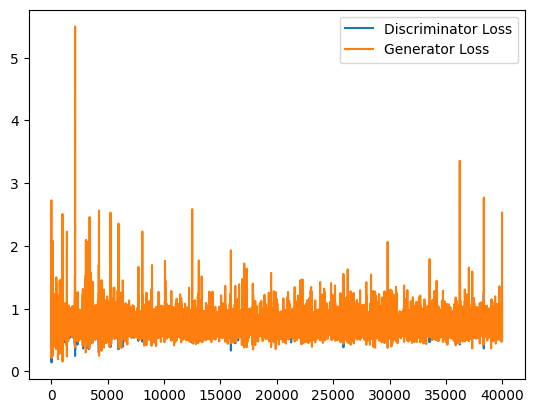

 23%|██▎       | 1002/4441 [01:31<29:46,  1.92it/s]

Epoch 10, batch 1000: FID = 165.6522


 45%|████▌     | 2002/4441 [03:01<21:01,  1.93it/s]

Epoch 10, batch 2000: FID = 182.8261


 68%|██████▊   | 3002/4441 [04:32<12:14,  1.96it/s]

Epoch 10, batch 3000: FID = 167.4313


 90%|█████████ | 4002/4441 [06:03<03:44,  1.95it/s]

Epoch 10, batch 4000: FID = 173.6563


100%|██████████| 4441/4441 [06:41<00:00, 11.06it/s]


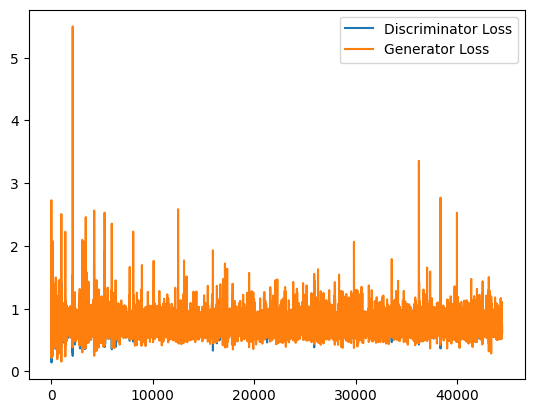

 23%|██▎       | 1003/4441 [01:30<22:11,  2.58it/s]

Epoch 11, batch 1000: FID = 179.2594


 45%|████▌     | 2003/4441 [03:01<15:55,  2.55it/s]

Epoch 11, batch 2000: FID = 179.5672


 68%|██████▊   | 3003/4441 [04:31<09:19,  2.57it/s]

Epoch 11, batch 3000: FID = 171.3152


 90%|█████████ | 4003/4441 [06:02<02:52,  2.55it/s]

Epoch 11, batch 4000: FID = 153.7192


100%|██████████| 4441/4441 [06:40<00:00, 11.08it/s]


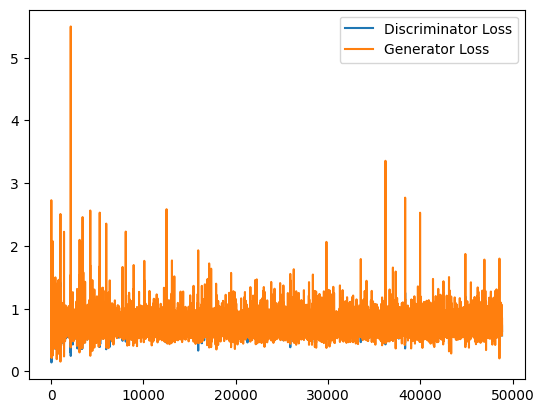

 23%|██▎       | 1002/4441 [01:30<29:46,  1.92it/s]

Epoch 12, batch 1000: FID = 183.7095


 45%|████▌     | 2002/4441 [03:01<20:58,  1.94it/s]

Epoch 12, batch 2000: FID = 168.5099


 68%|██████▊   | 3002/4441 [04:32<12:19,  1.95it/s]

Epoch 12, batch 3000: FID = 163.0410


 90%|█████████ | 4002/4441 [06:02<03:42,  1.98it/s]

Epoch 12, batch 4000: FID = 155.6041


100%|██████████| 4441/4441 [06:41<00:00, 11.07it/s]


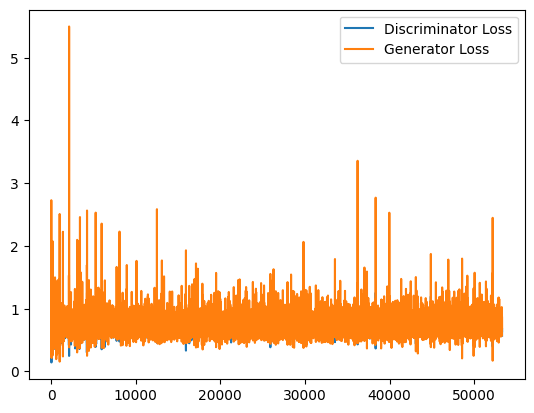

 23%|██▎       | 1003/4441 [01:30<22:01,  2.60it/s]

Epoch 13, batch 1000: FID = 172.9748


 45%|████▌     | 2002/4441 [03:01<21:19,  1.91it/s]

Epoch 13, batch 2000: FID = 172.9406


 68%|██████▊   | 3002/4441 [04:30<12:18,  1.95it/s]

Epoch 13, batch 3000: FID = 178.7028


 90%|█████████ | 4002/4441 [06:00<03:45,  1.95it/s]

Epoch 13, batch 4000: FID = 165.7802


100%|██████████| 4441/4441 [06:39<00:00, 11.13it/s]


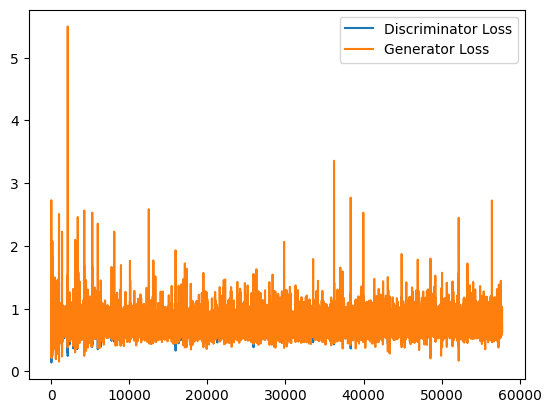

 23%|██▎       | 1003/4441 [01:30<22:04,  2.60it/s]

Epoch 14, batch 1000: FID = 147.4842


 45%|████▌     | 2003/4441 [03:00<15:34,  2.61it/s]

Epoch 14, batch 2000: FID = 181.9236


 68%|██████▊   | 3003/4441 [04:30<09:19,  2.57it/s]

Epoch 14, batch 3000: FID = 162.8621


 90%|█████████ | 4002/4441 [06:01<03:50,  1.91it/s]

Epoch 14, batch 4000: FID = 169.7231


100%|██████████| 4441/4441 [06:39<00:00, 11.12it/s]


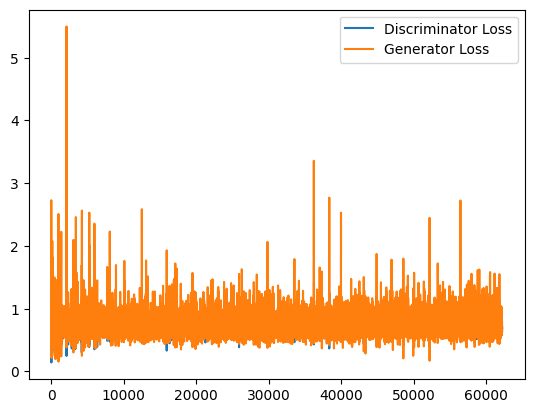

 23%|██▎       | 1002/4441 [01:30<29:32,  1.94it/s]

Epoch 15, batch 1000: FID = 160.7799


 45%|████▌     | 2002/4441 [03:02<20:55,  1.94it/s]

Epoch 15, batch 2000: FID = 152.4202


 68%|██████▊   | 3002/4441 [04:33<12:23,  1.94it/s]

Epoch 15, batch 3000: FID = 172.4753


 90%|█████████ | 4002/4441 [06:03<03:43,  1.96it/s]

Epoch 15, batch 4000: FID = 167.3940


100%|██████████| 4441/4441 [06:42<00:00, 11.04it/s]


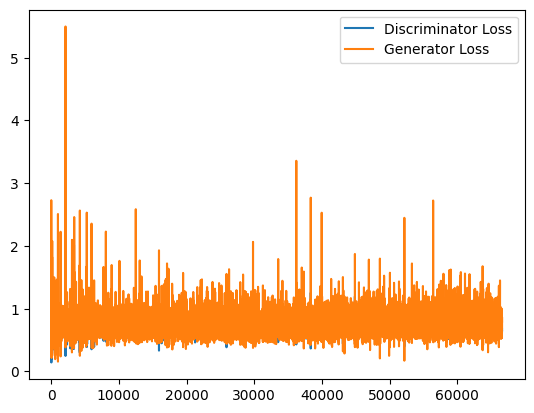

 23%|██▎       | 1003/4441 [01:31<22:18,  2.57it/s]

Epoch 16, batch 1000: FID = 153.2183


 45%|████▌     | 2003/4441 [03:01<15:47,  2.57it/s]

Epoch 16, batch 2000: FID = 162.6354


 68%|██████▊   | 3003/4441 [04:32<09:12,  2.60it/s]

Epoch 16, batch 3000: FID = 159.1198


 90%|█████████ | 4003/4441 [06:03<02:49,  2.59it/s]

Epoch 16, batch 4000: FID = 139.4139


100%|██████████| 4441/4441 [06:41<00:00, 11.05it/s]


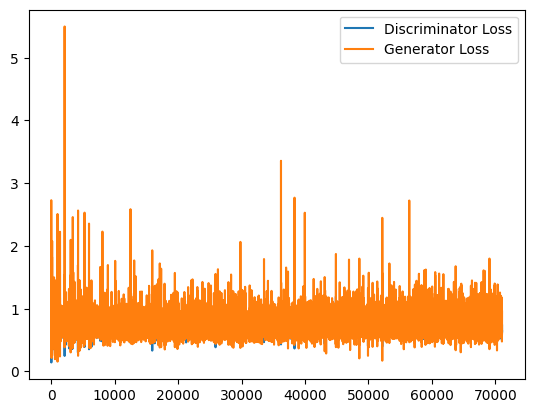

 23%|██▎       | 1003/4441 [01:30<21:50,  2.62it/s]

Epoch 17, batch 1000: FID = 145.7613


 45%|████▌     | 2002/4441 [03:01<21:17,  1.91it/s]

Epoch 17, batch 2000: FID = 180.2391


 68%|██████▊   | 3002/4441 [04:32<12:28,  1.92it/s]

Epoch 17, batch 3000: FID = 159.8716


 90%|█████████ | 4002/4441 [06:02<03:43,  1.96it/s]

Epoch 17, batch 4000: FID = 145.3589


100%|██████████| 4441/4441 [06:41<00:00, 11.07it/s]


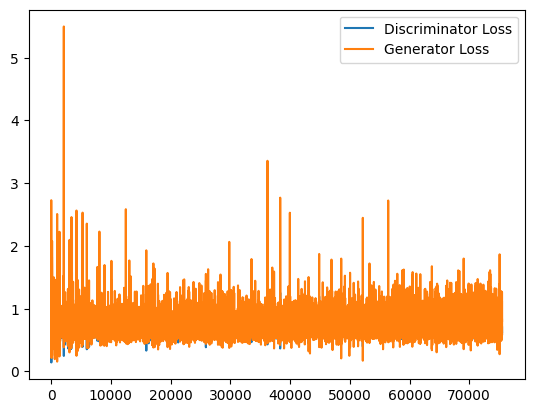

 23%|██▎       | 1003/4441 [01:30<22:07,  2.59it/s]

Epoch 18, batch 1000: FID = 150.7614


 45%|████▌     | 2003/4441 [03:01<15:36,  2.60it/s]

Epoch 18, batch 2000: FID = 176.5178


 68%|██████▊   | 3003/4441 [04:32<09:17,  2.58it/s]

Epoch 18, batch 3000: FID = 149.9705


 90%|█████████ | 4003/4441 [06:04<02:49,  2.58it/s]

Epoch 18, batch 4000: FID = 164.4966


100%|██████████| 4441/4441 [06:43<00:00, 11.01it/s]


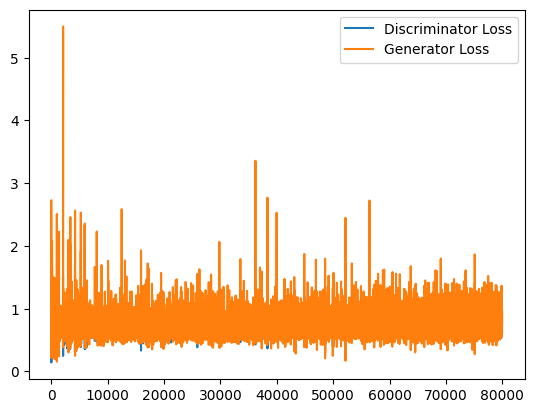

 23%|██▎       | 1003/4441 [01:31<22:14,  2.58it/s]

Epoch 19, batch 1000: FID = 166.3698


 45%|████▌     | 2003/4441 [03:01<15:40,  2.59it/s]

Epoch 19, batch 2000: FID = 161.0225


 68%|██████▊   | 3003/4441 [04:31<09:15,  2.59it/s]

Epoch 19, batch 3000: FID = 153.9117


 90%|█████████ | 4003/4441 [06:01<02:48,  2.59it/s]

Epoch 19, batch 4000: FID = 163.5802


100%|██████████| 4441/4441 [06:39<00:00, 11.12it/s]


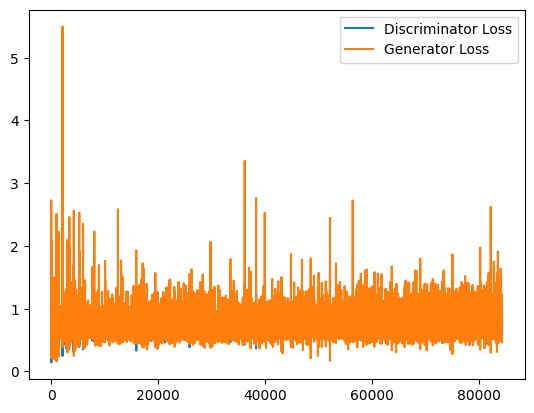

 23%|██▎       | 1002/4441 [01:30<29:33,  1.94it/s]

Epoch 20, batch 1000: FID = 151.0716


 45%|████▌     | 2002/4441 [03:00<20:48,  1.95it/s]

Epoch 20, batch 2000: FID = 176.2910


 68%|██████▊   | 3002/4441 [04:30<12:18,  1.95it/s]

Epoch 20, batch 3000: FID = 146.9856


 90%|█████████ | 4002/4441 [06:01<03:47,  1.93it/s]

Epoch 20, batch 4000: FID = 151.2635


100%|██████████| 4441/4441 [06:39<00:00, 11.11it/s]


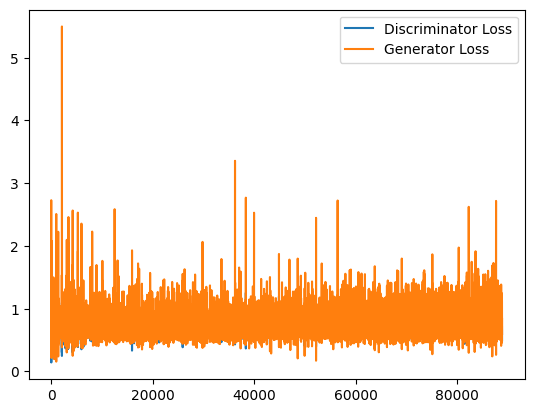

 23%|██▎       | 1002/4441 [01:30<29:23,  1.95it/s]

Epoch 21, batch 1000: FID = 146.5880


 45%|████▌     | 2002/4441 [03:00<21:23,  1.90it/s]

Epoch 21, batch 2000: FID = 161.8109


 68%|██████▊   | 3002/4441 [04:31<12:21,  1.94it/s]

Epoch 21, batch 3000: FID = 152.0844


 90%|█████████ | 4002/4441 [06:01<03:47,  1.93it/s]

Epoch 21, batch 4000: FID = 151.6387


100%|██████████| 4441/4441 [06:39<00:00, 11.11it/s]


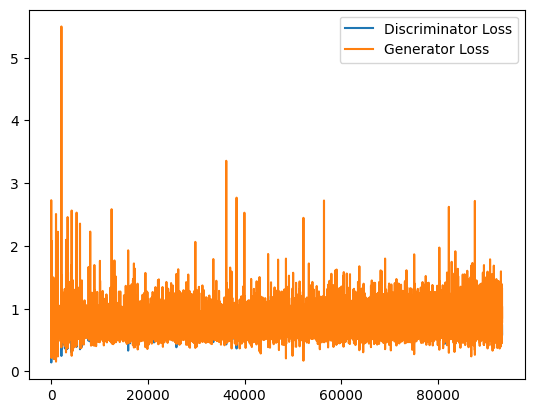

 23%|██▎       | 1002/4441 [01:30<28:56,  1.98it/s]

Epoch 22, batch 1000: FID = 163.1922


 45%|████▌     | 2002/4441 [03:00<20:44,  1.96it/s]

Epoch 22, batch 2000: FID = 160.9121


 68%|██████▊   | 3002/4441 [04:31<12:29,  1.92it/s]

Epoch 22, batch 3000: FID = 162.2712


 90%|█████████ | 4002/4441 [06:02<03:43,  1.96it/s]

Epoch 22, batch 4000: FID = 151.2942


100%|██████████| 4441/4441 [06:40<00:00, 11.09it/s]


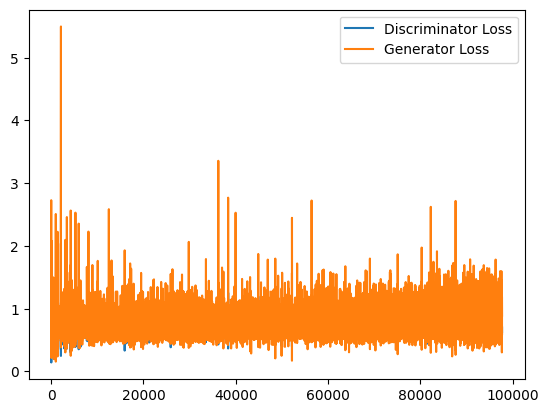

 23%|██▎       | 1003/4441 [01:28<22:04,  2.60it/s]

Epoch 23, batch 1000: FID = 164.3264


 45%|████▌     | 2003/4441 [02:56<15:32,  2.61it/s]

Epoch 23, batch 2000: FID = 162.4385


 68%|██████▊   | 3003/4441 [04:25<09:10,  2.61it/s]

Epoch 23, batch 3000: FID = 150.4319


 90%|█████████ | 4003/4441 [05:53<02:46,  2.62it/s]

Epoch 23, batch 4000: FID = 128.7849


100%|██████████| 4441/4441 [06:30<00:00, 11.37it/s]


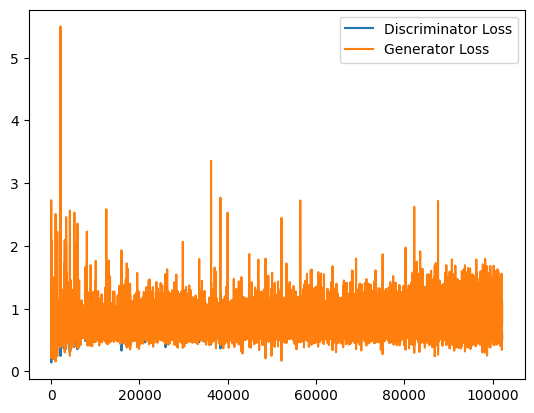

 23%|██▎       | 1003/4441 [01:29<22:08,  2.59it/s]

Epoch 24, batch 1000: FID = 168.5233


 45%|████▌     | 2003/4441 [02:57<15:32,  2.62it/s]

Epoch 24, batch 2000: FID = 160.1239


 68%|██████▊   | 3003/4441 [04:26<09:11,  2.61it/s]

Epoch 24, batch 3000: FID = 148.7205


 90%|█████████ | 4003/4441 [05:55<02:48,  2.60it/s]

Epoch 24, batch 4000: FID = 145.3307


100%|██████████| 4441/4441 [06:33<00:00, 11.28it/s]


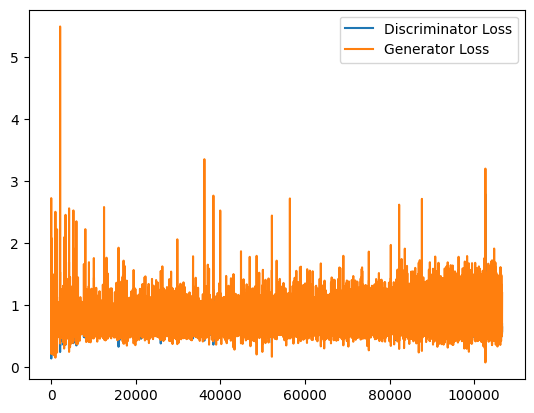

 23%|██▎       | 1003/4441 [01:29<22:09,  2.59it/s]

Epoch 25, batch 1000: FID = 144.4527


 45%|████▌     | 2003/4441 [02:58<15:39,  2.59it/s]

Epoch 25, batch 2000: FID = 170.0924


 68%|██████▊   | 3003/4441 [04:27<09:13,  2.60it/s]

Epoch 25, batch 3000: FID = 158.4984


 90%|█████████ | 4003/4441 [05:56<02:49,  2.58it/s]

Epoch 25, batch 4000: FID = 151.4867


100%|██████████| 4441/4441 [06:34<00:00, 11.26it/s]


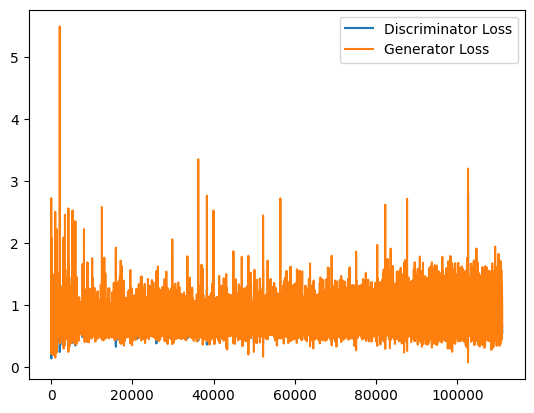

 23%|██▎       | 1003/4441 [01:29<21:58,  2.61it/s]

Epoch 26, batch 1000: FID = 148.2207


 45%|████▌     | 2003/4441 [02:58<15:34,  2.61it/s]

Epoch 26, batch 2000: FID = 150.1426


 68%|██████▊   | 3003/4441 [04:27<09:15,  2.59it/s]

Epoch 26, batch 3000: FID = 138.2719


 90%|█████████ | 4002/4441 [05:56<03:13,  2.27it/s]

Epoch 26, batch 4000: FID = 149.8681


100%|██████████| 4441/4441 [06:35<00:00, 11.24it/s]


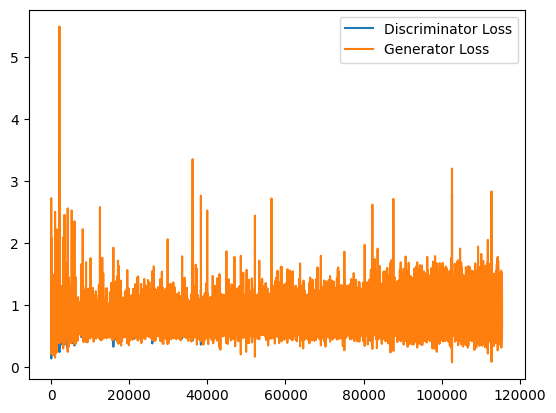

 23%|██▎       | 1003/4441 [01:29<21:56,  2.61it/s]

Epoch 27, batch 1000: FID = 147.6366


 45%|████▌     | 2003/4441 [02:58<15:44,  2.58it/s]

Epoch 27, batch 2000: FID = 153.9929


 68%|██████▊   | 3003/4441 [04:27<09:11,  2.61it/s]

Epoch 27, batch 3000: FID = 152.8092


 90%|█████████ | 4003/4441 [05:55<02:49,  2.58it/s]

Epoch 27, batch 4000: FID = 164.9842


100%|██████████| 4441/4441 [06:33<00:00, 11.29it/s]


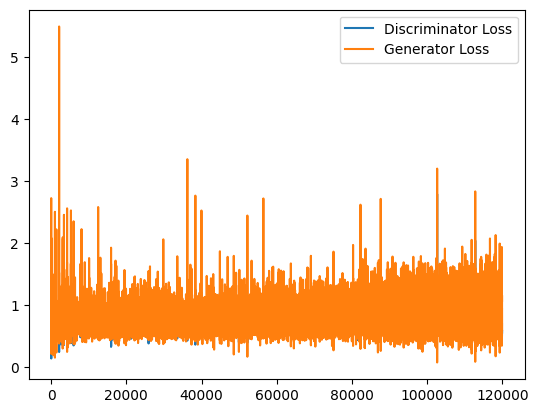

 23%|██▎       | 1002/4441 [01:29<29:31,  1.94it/s]

Epoch 28, batch 1000: FID = 151.2529


 45%|████▌     | 2002/4441 [02:57<21:02,  1.93it/s]

Epoch 28, batch 2000: FID = 168.5345


 68%|██████▊   | 3002/4441 [04:26<12:20,  1.94it/s]

Epoch 28, batch 3000: FID = 149.1223


 90%|█████████ | 4002/4441 [05:54<03:46,  1.94it/s]

Epoch 28, batch 4000: FID = 159.1407


100%|██████████| 4441/4441 [06:32<00:00, 11.32it/s]


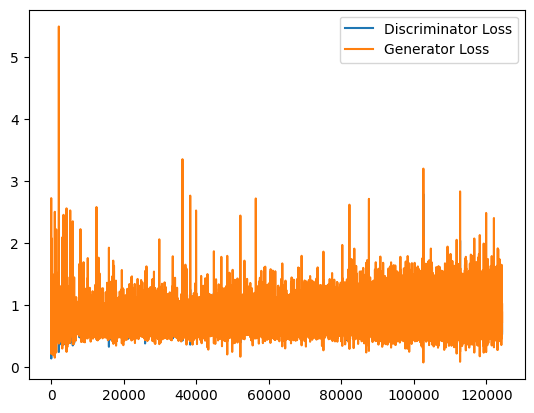

 23%|██▎       | 1003/4441 [01:28<21:53,  2.62it/s]

Epoch 29, batch 1000: FID = 151.5890


 45%|████▌     | 2003/4441 [02:57<15:36,  2.60it/s]

Epoch 29, batch 2000: FID = 166.6403


 68%|██████▊   | 3003/4441 [04:25<09:07,  2.63it/s]

Epoch 29, batch 3000: FID = 156.6718


 90%|█████████ | 4003/4441 [05:54<02:49,  2.59it/s]

Epoch 29, batch 4000: FID = 161.1898


100%|██████████| 4441/4441 [06:31<00:00, 11.33it/s]


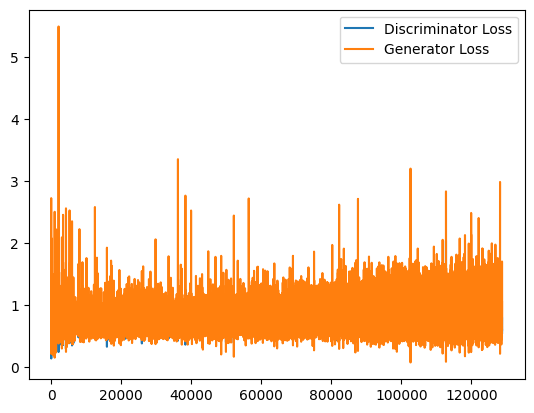

 23%|██▎       | 1003/4441 [01:28<21:56,  2.61it/s]

Epoch 30, batch 1000: FID = 161.0395


 45%|████▌     | 2001/4441 [02:57<21:05,  1.93it/s]

Epoch 30, batch 2000: FID = 161.1143


 68%|██████▊   | 3003/4441 [04:25<09:18,  2.58it/s]

Epoch 30, batch 3000: FID = 146.4952


 90%|█████████ | 4003/4441 [05:54<02:48,  2.60it/s]

Epoch 30, batch 4000: FID = 142.3945


100%|██████████| 4441/4441 [06:31<00:00, 11.34it/s]


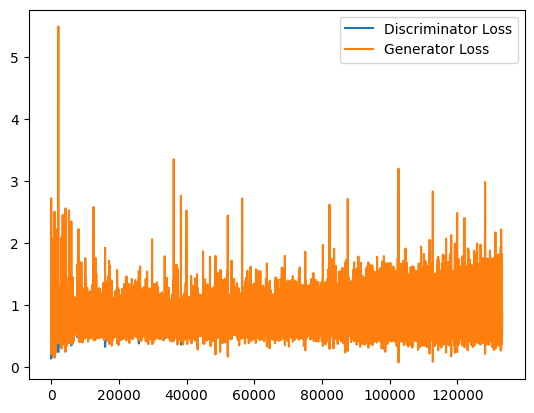

 23%|██▎       | 1003/4441 [01:29<21:57,  2.61it/s]

Epoch 31, batch 1000: FID = 151.1443


 45%|████▌     | 2003/4441 [02:58<15:42,  2.59it/s]

Epoch 31, batch 2000: FID = 156.1898


 68%|██████▊   | 3003/4441 [04:28<09:09,  2.62it/s]

Epoch 31, batch 3000: FID = 149.6679


 90%|█████████ | 4003/4441 [05:57<02:48,  2.61it/s]

Epoch 31, batch 4000: FID = 155.5809


100%|██████████| 4441/4441 [06:35<00:00, 11.24it/s]


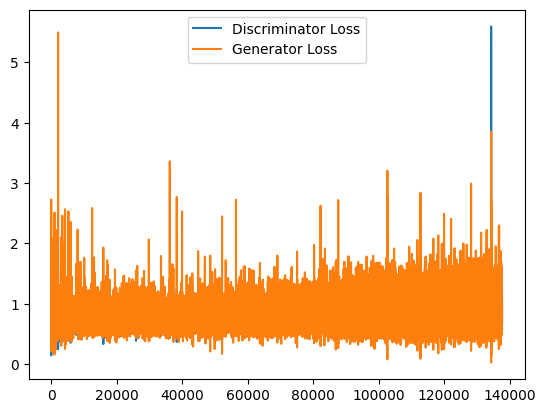

 23%|██▎       | 1003/4441 [01:28<22:01,  2.60it/s]

Epoch 32, batch 1000: FID = 147.5799


 45%|████▌     | 2003/4441 [02:56<15:41,  2.59it/s]

Epoch 32, batch 2000: FID = 159.3106


 68%|██████▊   | 3003/4441 [04:25<09:16,  2.58it/s]

Epoch 32, batch 3000: FID = 175.6691


 90%|█████████ | 4003/4441 [05:53<02:48,  2.60it/s]

Epoch 32, batch 4000: FID = 139.4405


100%|██████████| 4441/4441 [06:30<00:00, 11.36it/s]


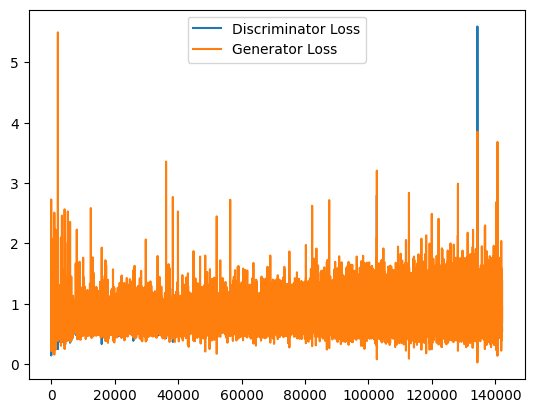

 23%|██▎       | 1003/4441 [01:28<21:55,  2.61it/s]

Epoch 33, batch 1000: FID = 142.8112


 45%|████▌     | 2003/4441 [02:56<15:46,  2.58it/s]

Epoch 33, batch 2000: FID = 139.8618


 68%|██████▊   | 3003/4441 [04:23<09:16,  2.59it/s]

Epoch 33, batch 3000: FID = 141.9230


 90%|█████████ | 4003/4441 [05:52<02:47,  2.61it/s]

Epoch 33, batch 4000: FID = 140.8060


100%|██████████| 4441/4441 [06:29<00:00, 11.39it/s]


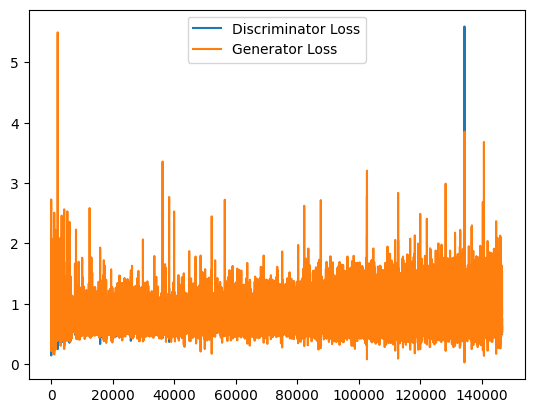

 23%|██▎       | 1003/4441 [01:28<22:03,  2.60it/s]

Epoch 34, batch 1000: FID = 145.1647


 45%|████▌     | 2003/4441 [02:57<15:39,  2.59it/s]

Epoch 34, batch 2000: FID = 158.6443


 68%|██████▊   | 3003/4441 [04:25<09:19,  2.57it/s]

Epoch 34, batch 3000: FID = 138.3790


 90%|█████████ | 4003/4441 [05:54<02:49,  2.58it/s]

Epoch 34, batch 4000: FID = 145.8529


100%|██████████| 4441/4441 [06:31<00:00, 11.33it/s]


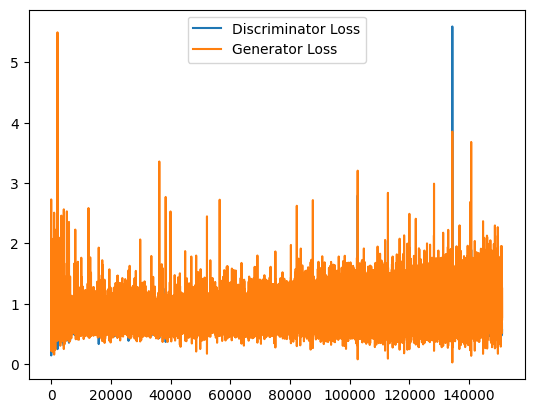

 23%|██▎       | 1003/4441 [01:29<22:06,  2.59it/s]

Epoch 35, batch 1000: FID = 150.6172


 45%|████▌     | 2003/4441 [02:57<15:28,  2.63it/s]

Epoch 35, batch 2000: FID = 150.2178


 68%|██████▊   | 3003/4441 [04:25<09:20,  2.56it/s]

Epoch 35, batch 3000: FID = 157.0690


 90%|█████████ | 4003/4441 [05:54<02:49,  2.59it/s]

Epoch 35, batch 4000: FID = 158.0378


100%|██████████| 4441/4441 [06:32<00:00, 11.33it/s]


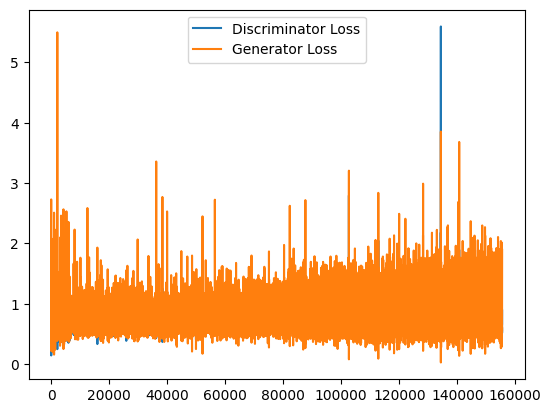

 23%|██▎       | 1003/4441 [01:28<21:50,  2.62it/s]

Epoch 36, batch 1000: FID = 146.6753


 45%|████▌     | 2003/4441 [02:57<15:35,  2.61it/s]

Epoch 36, batch 2000: FID = 150.1468


 68%|██████▊   | 3003/4441 [04:25<09:14,  2.59it/s]

Epoch 36, batch 3000: FID = 136.9365


 90%|█████████ | 4003/4441 [05:54<02:47,  2.61it/s]

Epoch 36, batch 4000: FID = 135.3322


100%|██████████| 4441/4441 [06:31<00:00, 11.33it/s]


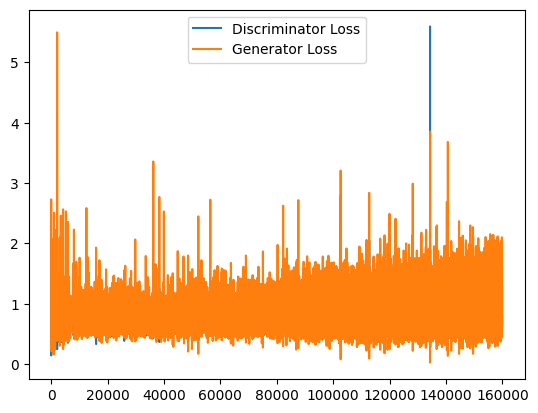

 23%|██▎       | 1003/4441 [01:29<21:46,  2.63it/s]

Epoch 37, batch 1000: FID = 140.0865


 45%|████▌     | 2003/4441 [02:57<15:41,  2.59it/s]

Epoch 37, batch 2000: FID = 140.3807


 68%|██████▊   | 3003/4441 [04:26<09:09,  2.62it/s]

Epoch 37, batch 3000: FID = 148.4708


 90%|█████████ | 4003/4441 [05:55<02:47,  2.62it/s]

Epoch 37, batch 4000: FID = 140.9341


100%|██████████| 4441/4441 [06:32<00:00, 11.31it/s]


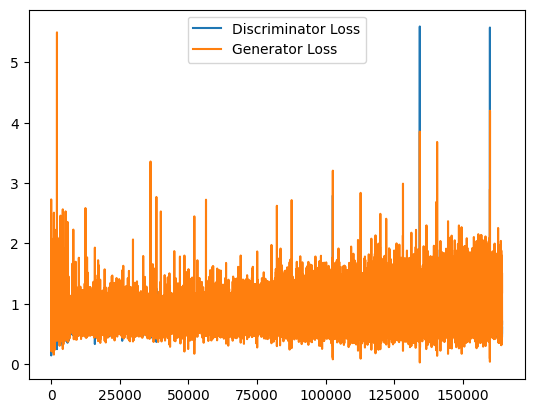

 23%|██▎       | 1003/4441 [01:29<22:02,  2.60it/s]

Epoch 38, batch 1000: FID = 149.8605


 45%|████▌     | 2001/4441 [02:57<21:13,  1.92it/s]

Epoch 38, batch 2000: FID = 139.1500


 68%|██████▊   | 3003/4441 [04:25<09:12,  2.60it/s]

Epoch 38, batch 3000: FID = 166.8056


 90%|█████████ | 4003/4441 [05:54<02:49,  2.58it/s]

Epoch 38, batch 4000: FID = 154.6799


100%|██████████| 4441/4441 [06:31<00:00, 11.34it/s]


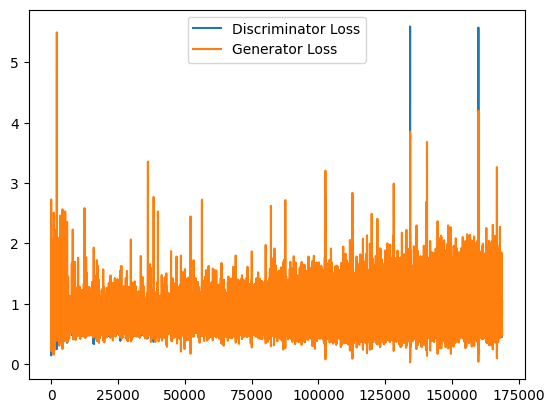

 23%|██▎       | 1003/4441 [01:28<21:42,  2.64it/s]

Epoch 39, batch 1000: FID = 138.6905


 45%|████▌     | 2003/4441 [02:56<15:35,  2.61it/s]

Epoch 39, batch 2000: FID = 154.2204


 68%|██████▊   | 3003/4441 [04:25<09:16,  2.58it/s]

Epoch 39, batch 3000: FID = 149.3060


 90%|█████████ | 4003/4441 [05:54<02:50,  2.57it/s]

Epoch 39, batch 4000: FID = 135.4203


100%|██████████| 4441/4441 [06:32<00:00, 11.33it/s]


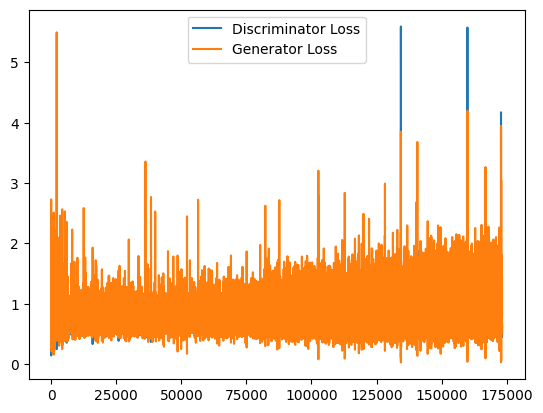

 23%|██▎       | 1003/4441 [01:30<21:50,  2.62it/s]

Epoch 40, batch 1000: FID = 134.1535


 45%|████▌     | 2003/4441 [02:59<15:30,  2.62it/s]

Epoch 40, batch 2000: FID = 156.9814


 68%|██████▊   | 3003/4441 [04:28<09:13,  2.60it/s]

Epoch 40, batch 3000: FID = 144.9302


 90%|█████████ | 4003/4441 [05:58<02:48,  2.60it/s]

Epoch 40, batch 4000: FID = 146.8047


100%|██████████| 4441/4441 [06:35<00:00, 11.22it/s]


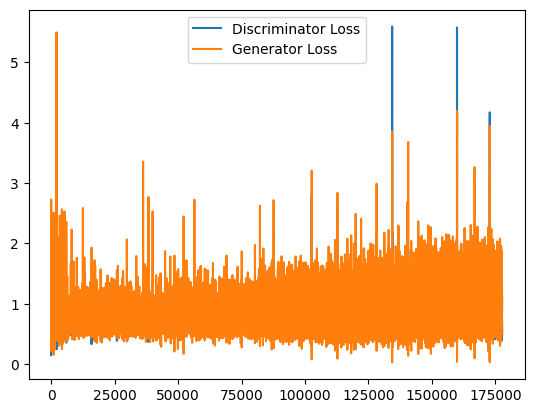

 23%|██▎       | 1001/4441 [01:29<29:42,  1.93it/s]

Epoch 41, batch 1000: FID = 139.5234


 45%|████▌     | 2003/4441 [02:59<15:29,  2.62it/s]

Epoch 41, batch 2000: FID = 142.0353


 68%|██████▊   | 3003/4441 [04:28<09:12,  2.60it/s]

Epoch 41, batch 3000: FID = 141.6228


 90%|█████████ | 4003/4441 [05:57<02:50,  2.57it/s]

Epoch 41, batch 4000: FID = 152.3347


100%|██████████| 4441/4441 [06:35<00:00, 11.22it/s]


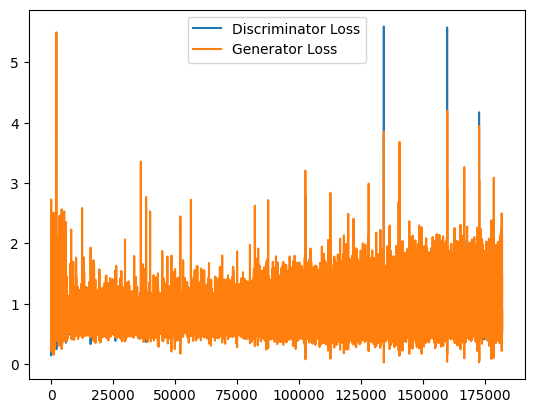

 23%|██▎       | 1002/4441 [01:30<29:29,  1.94it/s]

Epoch 42, batch 1000: FID = 133.2597


 45%|████▌     | 2002/4441 [02:59<20:54,  1.94it/s]

Epoch 42, batch 2000: FID = 150.1721


 68%|██████▊   | 3002/4441 [04:29<12:20,  1.94it/s]

Epoch 42, batch 3000: FID = 152.2648


 90%|█████████ | 4003/4441 [05:59<02:48,  2.60it/s]

Epoch 42, batch 4000: FID = 137.5807


100%|██████████| 4441/4441 [06:37<00:00, 11.19it/s]


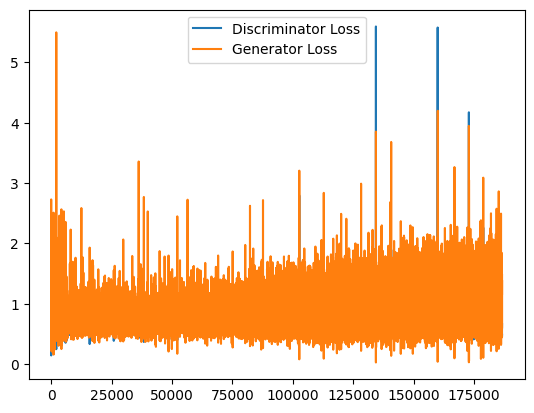

 23%|██▎       | 1003/4441 [01:29<22:14,  2.58it/s]

Epoch 43, batch 1000: FID = 144.7330


 45%|████▌     | 2003/4441 [02:59<15:52,  2.56it/s]

Epoch 43, batch 2000: FID = 155.5713


 68%|██████▊   | 3003/4441 [04:28<09:13,  2.60it/s]

Epoch 43, batch 3000: FID = 153.4082


 90%|█████████ | 4003/4441 [05:56<02:48,  2.61it/s]

Epoch 43, batch 4000: FID = 132.8722


100%|██████████| 4441/4441 [06:34<00:00, 11.27it/s]


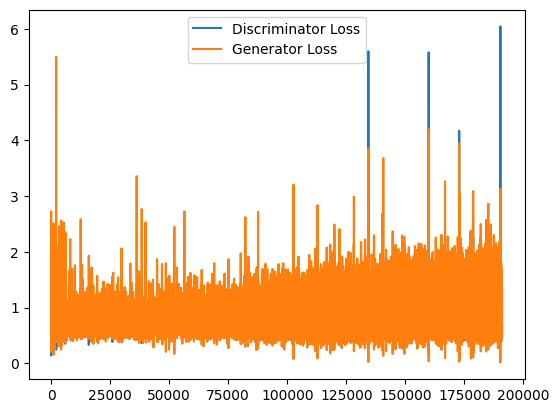

 23%|██▎       | 1002/4441 [01:28<29:46,  1.92it/s]

Epoch 44, batch 1000: FID = 157.6652


 45%|████▌     | 2002/4441 [02:57<20:44,  1.96it/s]

Epoch 44, batch 2000: FID = 149.1530


 68%|██████▊   | 3002/4441 [04:25<12:04,  1.99it/s]

Epoch 44, batch 3000: FID = 133.4680


 90%|█████████ | 4002/4441 [05:53<03:46,  1.94it/s]

Epoch 44, batch 4000: FID = 143.6789


100%|██████████| 4441/4441 [06:30<00:00, 11.38it/s]


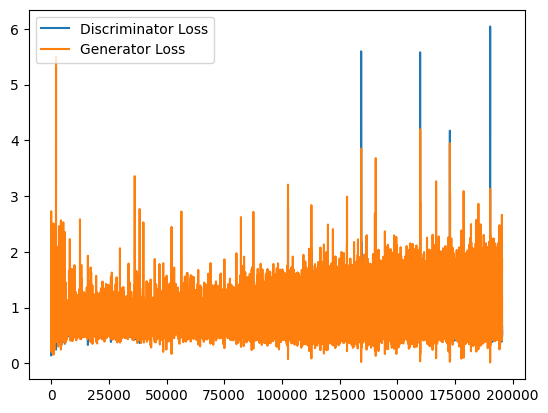

 23%|██▎       | 1002/4441 [01:28<29:35,  1.94it/s]

Epoch 45, batch 1000: FID = 144.2905


 45%|████▌     | 2002/4441 [02:55<21:03,  1.93it/s]

Epoch 45, batch 2000: FID = 153.7400


 68%|██████▊   | 3002/4441 [04:24<12:15,  1.96it/s]

Epoch 45, batch 3000: FID = 142.3761


 90%|█████████ | 4002/4441 [05:54<03:44,  1.96it/s]

Epoch 45, batch 4000: FID = 141.8369


100%|██████████| 4441/4441 [06:32<00:00, 11.31it/s]


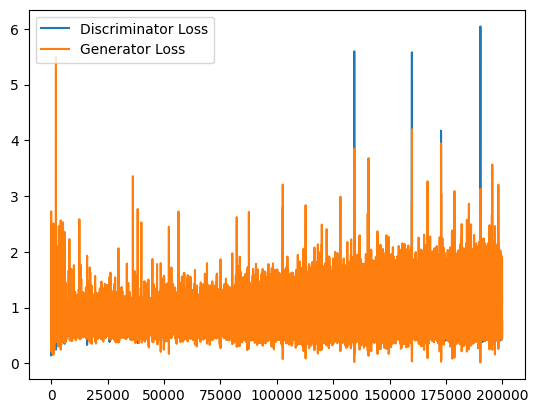

 23%|██▎       | 1003/4441 [01:28<22:07,  2.59it/s]

Epoch 46, batch 1000: FID = 151.3085


 45%|████▌     | 2003/4441 [02:56<15:38,  2.60it/s]

Epoch 46, batch 2000: FID = 159.9958


 68%|██████▊   | 3003/4441 [04:23<09:06,  2.63it/s]

Epoch 46, batch 3000: FID = 155.7105


 90%|█████████ | 4003/4441 [05:51<02:45,  2.65it/s]

Epoch 46, batch 4000: FID = 150.6158


100%|██████████| 4441/4441 [06:28<00:00, 11.44it/s]


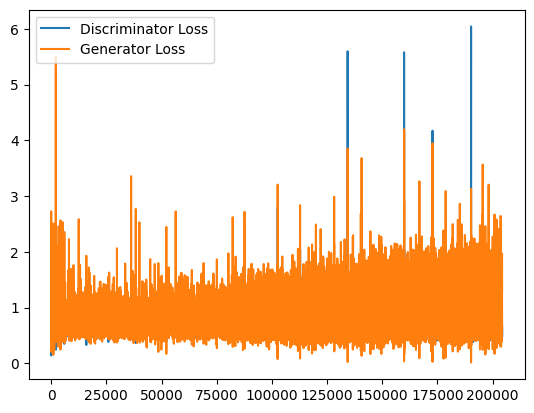

 23%|██▎       | 1002/4441 [01:27<28:53,  1.98it/s]

Epoch 47, batch 1000: FID = 132.6028


 45%|████▌     | 2002/4441 [02:54<20:35,  1.97it/s]

Epoch 47, batch 2000: FID = 158.1883


 68%|██████▊   | 3002/4441 [04:22<12:11,  1.97it/s]

Epoch 47, batch 3000: FID = 143.4316


 90%|█████████ | 4002/4441 [05:50<03:44,  1.95it/s]

Epoch 47, batch 4000: FID = 155.6080


100%|██████████| 4441/4441 [06:28<00:00, 11.43it/s]


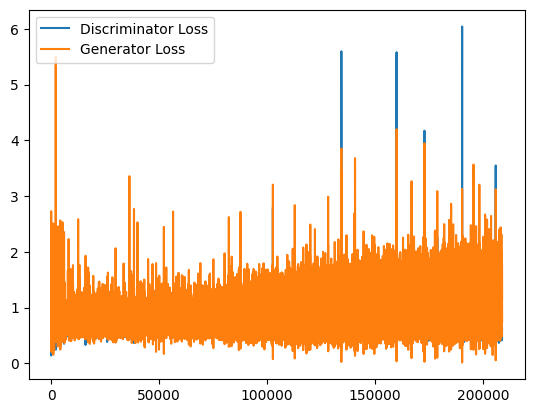

 23%|██▎       | 1003/4441 [01:29<21:59,  2.61it/s]

Epoch 48, batch 1000: FID = 140.4241


 45%|████▌     | 2003/4441 [02:59<15:48,  2.57it/s]

Epoch 48, batch 2000: FID = 149.1499


 68%|██████▊   | 3003/4441 [04:28<09:15,  2.59it/s]

Epoch 48, batch 3000: FID = 139.2442


 90%|█████████ | 4003/4441 [05:57<02:48,  2.60it/s]

Epoch 48, batch 4000: FID = 140.2239


100%|██████████| 4441/4441 [06:35<00:00, 11.23it/s]


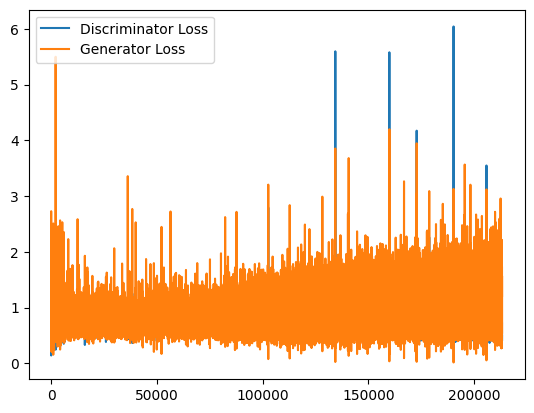

 23%|██▎       | 1003/4441 [01:28<21:53,  2.62it/s]

Epoch 49, batch 1000: FID = 148.3463


 45%|████▌     | 2003/4441 [02:56<15:35,  2.61it/s]

Epoch 49, batch 2000: FID = 148.8700


 68%|██████▊   | 3003/4441 [04:25<09:03,  2.64it/s]

Epoch 49, batch 3000: FID = 130.3934


 90%|█████████ | 4003/4441 [05:52<02:48,  2.59it/s]

Epoch 49, batch 4000: FID = 140.0638


100%|██████████| 4441/4441 [06:30<00:00, 11.38it/s]


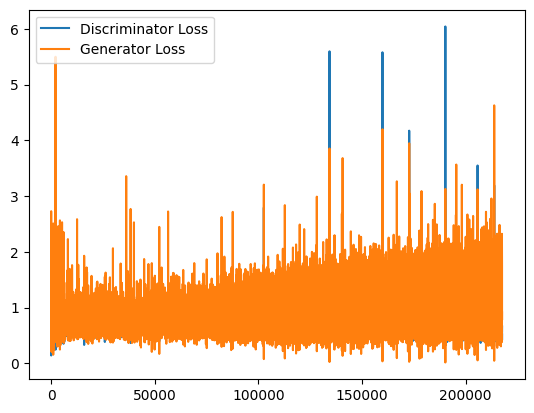

 23%|██▎       | 1003/4441 [01:28<22:08,  2.59it/s]

Epoch 50, batch 1000: FID = 140.6350


 45%|████▌     | 2003/4441 [02:56<15:29,  2.62it/s]

Epoch 50, batch 2000: FID = 140.2275


 68%|██████▊   | 3003/4441 [04:25<09:08,  2.62it/s]

Epoch 50, batch 3000: FID = 144.8520


 90%|█████████ | 4003/4441 [05:53<02:48,  2.60it/s]

Epoch 50, batch 4000: FID = 150.3981


100%|██████████| 4441/4441 [06:30<00:00, 11.36it/s]


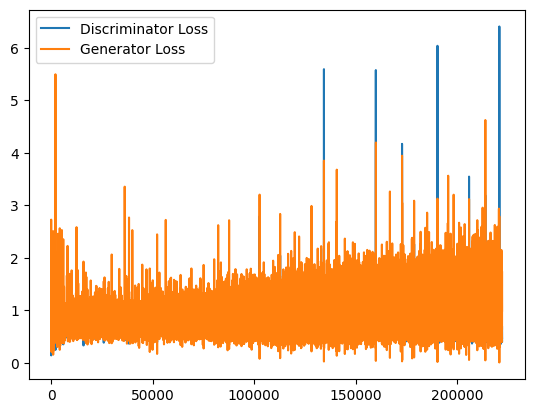

In [8]:
#Train with evaluation

def train_gan(epochs, fid_freq):
    d_loss = []
    g_loss = []
    for epoch in range(epochs):
        for idx, real in enumerate(tqdm(train_ds)):
            batch_size = real.shape[0]
            random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake = generator(random_latent_vectors)

                loss_disc_real = loss_fn(tf.ones((batch_size, 1)), discriminator(real))
                loss_disc_fake = loss_fn(tf.zeros((batch_size, 1)), discriminator(fake))
                loss_disc = (loss_disc_real + loss_disc_fake) / 2

                loss_gen = loss_fn(tf.ones((batch_size, 1)), discriminator(fake))

            grads_disc = disc_tape.gradient(loss_disc, discriminator.trainable_weights)
            disc_opt.apply_gradients(zip(grads_disc, discriminator.trainable_weights))

            grads_gen = gen_tape.gradient(loss_gen, generator.trainable_weights)
            gen_opt.apply_gradients(zip(grads_gen, generator.trainable_weights))

            d_loss.append(loss_disc.numpy())
            g_loss.append(loss_gen.numpy())

            #MIN size 299x299 img
            if idx % fid_freq == 0 and idx > 0:
                #rescale
                #real_images = tf.image.resize(real, (299, 299))
                #fake_images = generator(random_latent_vectors))
                #fake_images = tf.image.resize(fake_images, (299, 299))
                fid = get_fid_score(real, fake)
                print(f'Epoch {epoch + 1}, batch {idx}: FID = {fid:.4f}') #FID score
            if idx % 1000 == 0:
                img = tf.keras.preprocessing.image.array_to_img(fake[0])
                #save to own dir or google drive here
                img.save(f"/content/drive/MyDrive/img_align_celeba/Generated_Images/V2_generated_img_{epoch:03d}_{idx}.png")

                            
        plt.plot(d_loss, label='Discriminator Loss')
        plt.plot(g_loss, label='Generator Loss')
        plt.legend()
        plt.show()

epochs = 50
fid_freq = 1000
train_gan(epochs, fid_freq)